In [2]:
!pip3 install xgboost
!pip3 install decision-tree-morfist
!pip3 install catboost

In [1]:
import config
import ast

import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import statistics

from utils.pandas_dataframe import grid_display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from itertools import permutations
import gc

# validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from morfist import MixedRandomForest
from catboost import CatBoostRegressor

# grid search
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.model_selection import GridSearchCV


from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor

from IPython.display import display


%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format',lambda x: '%.2f' % x)
# pd.set_option('display.max_rows', 5)
pd.set_option('display.max_rows', None)

In [3]:
data = pd.read_excel('../Data/2022-train-v2.xlsx')

In [4]:
print(f"train shape : {data.shape}")

train shape : (635, 131)


In [5]:
data_y = data[['sensor_point5_i_value', 'sensor_point6_i_value',\
               'sensor_point7_i_value', 'sensor_point8_i_value',\
               'sensor_point9_i_value', 'sensor_point10_i_value']]
data_x = data.drop(['sensor_point5_i_value', 'sensor_point6_i_value',\
                    'sensor_point7_i_value', 'sensor_point8_i_value',\
                    'sensor_point9_i_value', 'sensor_point10_i_value'], axis=1)

In [6]:
def Col_types(Data):
    Column_types = Data.dtypes.to_frame().reset_index()
    Column_types.columns = ['ColumnName', 'Type']
    Column_types.sort_values( by= 'Type', inplace = True)
    return Column_types

def Missing_Counts(Data):
    missing = Data.isnull().sum()
    missing = missing[ missing >0]
    missing.sort_values( inplace=True)
    Missing_Count = pd.DataFrame({ 'ColumnName':missing.index, 'MissingCount':missing.values})
    Missing_Count['Percentage(%)'] = Missing_Count['MissingCount'].apply(lambda x:round(x/Data.shape[0]*100,2))
    return Missing_Count

### 檢查缺失值

In [7]:
display(Missing_Counts(data_x))

,ColumnName,MissingCount,Percentage(%)
0,clean_ph4,286,45.04
1,clean_ph5,286,45.04
2,clean_ph7,286,45.04


In [8]:
display(Missing_Counts(data_y))

,ColumnName,MissingCount,Percentage(%)


In [9]:
data_x = data_x.fillna(0)

### 檢查資料屬性

In [10]:
display(Col_types(data_x))

,ColumnName,Type
0,clean_temp,float64
90,painting_g11_act_hvv,float64
89,painting_g11_act_t_air,float64
88,painting_g11_act_f_air,float64
87,painting_g11_act_a_air,float64
86,painting_g10_act_hvc,float64
85,painting_g10_act_hvv,float64
84,painting_g10_act_t_air,float64
83,painting_g10_act_f_air,float64
82,painting_g10_act_a_air,float64


# 1.X變數標準化

In [11]:
# X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, train_size = 0.8, random_state = 3)

# X變數標準化
scaler = StandardScaler().fit(data_x)
data_x_S = scaler.transform(data_x)

# 2.迴圈計算每個Y在每個模型下的最佳超參數，並計算RMSE值

In [12]:
# 分別計算每個Model的最佳超參數及RMSE，以判斷6個 Y的最佳 Model
# model(含超參數設定)
Lasso_params_list = []
Ridge_params_list = []
XGB_params_list = []
KN_params_list = []
Ada_params_list = []
Cat_params_list = []

# K-fold RMSE
Lasso_RMSE = []
Ridge_RMSE = []
XGB_RMSE = []
KN_RMSE = []
Ada_RMSE = []
Cat_RMSE = []

Model_result = pd.DataFrame({})

for i in range(6):

# Gridsearch超參數範圍
  

# 1. Lasso_model
    config.Lassocv.fit(data_x_S, data_y.iloc[:,i])

    poly_Lasso_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('std_scaler', StandardScaler()),
                               ('lasso_reg', Lasso(alpha = config.Lassocv.alpha_))
                              ])
    
    Lasso_params_list.append({'alpha':config.Lassocv.alpha_})
    
    # 訓練模型，計算train, test的RMSE
    Lasso_RMSE.append(-cross_val_score(poly_Lasso_reg, 
                                      data_x, data_y.iloc[:,i], 
                                      cv = 5, 
                                      scoring = 'neg_root_mean_squared_error').mean())
    
    poly_Lasso_reg.fit(data_x, data_y.iloc[:,i])
    

# 2. Ridge_model
    # Ridge超參數

    config.Ridgecv.fit(data_x_S, data_y.iloc[:,i])
    poly_Ridge_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('std_scaler', StandardScaler()),
                               ('lasso_reg', Ridge(alpha = config.Ridgecv.alpha_))
                              ])
    
    Ridge_params_list.append({'alpha':config.Ridgecv.alpha_})
    
    # 訓練模型，計算train, test的RMSE
    Ridge_RMSE.append(-cross_val_score(poly_Ridge_reg, 
                                      data_x, data_y.iloc[:,i], 
                                      cv = 5, 
                                      scoring = 'neg_root_mean_squared_error').mean())
    
    poly_Ridge_reg.fit(data_x, data_y.iloc[:,i])

# 3. XGB_model
    # XGBM超參數
    config.grid_search_xgbm.fit(data_x_S, data_y.iloc[:,i])
    
    poly_XGB_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                            ('std_scaler', StandardScaler()),
                            ('xgb_reg', xgb.XGBRegressor(**config.grid_search_xgbm.best_params_))
                            ])
    
    XGB_params_list.append(config.grid_search_xgbm.best_params_)
    # 訓練模型，計算train, test的RMSE
    

    XGB_RMSE.append(-cross_val_score(poly_XGB_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error').mean())
    
    poly_XGB_reg.fit(data_x, data_y.iloc[:,i])


# 4. KN_model
    # KN超參數

    config.grid_search_KN.fit(data_x_S, data_y.iloc[:,i])

    poly_KN_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config.grid_search_KN.best_params_))
                        ])
    
    KN_params_list.append(config.grid_search_KN.best_params_)
    # 訓練模型，計算train, test的RMSE
    
    KN_RMSE.append(-cross_val_score(poly_KN_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error').mean())
    
    poly_KN_reg.fit(data_x, data_y.iloc[:,i])    

# 5. Ada_model

    config.grid_search_Ada.fit(data_x_S, data_y.iloc[:,i])

    poly_Ada_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                             ('std_scaler', StandardScaler()),
                             ('Ada', AdaBoostRegressor(**config.grid_search_Ada.best_params_))
                            ]) 
    
    Ada_params_list.append(config.grid_search_Ada.best_params_)
    
    # 訓練模型，計算train, test的RMSE
    Ada_RMSE.append(-cross_val_score(poly_Ada_reg, 
                                     data_x, data_y.iloc[:,i], 
                                     cv = 5, 
                                     scoring = 'neg_root_mean_squared_error').mean())
    
    poly_Ada_reg.fit(data_x, data_y.iloc[:,i])        

    
# 6. Cat_model

    config.grid_search_Cat.fit(data_x_S, data_y.iloc[:,i])

    poly_Cat_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                             ('std_scaler', StandardScaler()),
                             ('Cat', CatBoostRegressor(**config.grid_search_Cat.best_params_))
                            ]) 
    
    Cat_params_list.append(config.grid_search_Cat.best_params_)
    
    # 訓練模型，計算train, test的RMSE
    Cat_RMSE.append(-cross_val_score(poly_Cat_reg, 
                                     data_x, data_y.iloc[:,i], 
                                     cv = 5, 
                                     scoring = 'neg_root_mean_squared_error').mean())
    
    poly_Cat_reg.fit(data_x, data_y.iloc[:,i])       

    
# **各模型預測結果放入Model_result
    
    Model_result['Actual_'+ data_y.columns.tolist()[i]] = data_y.iloc[:,i]
    Model_result['Lasso_'+ data_y.columns.tolist()[i]] = poly_Lasso_reg.predict(data_x)
    Model_result['Ridge_'+ data_y.columns.tolist()[i]] = poly_Ridge_reg.predict(data_x)
    Model_result['XGB_'+ data_y.columns.tolist()[i]] = poly_XGB_reg.predict(data_x)
    Model_result['KN_'+ data_y.columns.tolist()[i]] = poly_KN_reg.predict(data_x)
    Model_result['Ada_'+ data_y.columns.tolist()[i]] = poly_Ada_reg.predict(data_x)    
    Model_result['Cat_'+ data_y.columns.tolist()[i]] = poly_Cat_reg.predict(data_x)  
    
# list 串接成 pandas表格    
Model_RMSE = pd.DataFrame({'Lasso':Lasso_params_list,
                           'Lasso_RMSE':Lasso_RMSE,
                           'Ridge':Ridge_params_list,
                           'Ridge_RMSE':Ridge_RMSE,
                           'XGB':XGB_params_list,
                           'XGB_RMSE':XGB_RMSE,
                           'KN':KN_params_list,
                           'KN_RMSE':KN_RMSE,
                           'Ada':Ada_params_list,
                           'Ada_RMSE':Ada_RMSE,
                           'Cat':Cat_params_list,
                           'Cat_RMSE':Cat_RMSE
                          }, index = list(data_y.columns))

display(Model_RMSE)
display(Model_result)

# 資料輸出到Excel檔案
output = pd.ExcelWriter('../Data/output.xlsx')
Model_RMSE.to_excel(output, sheet_name = 'Model_RMSE',index = False)
Model_result.to_excel(output, sheet_name = 'Model_result',index = False)

output.save()

0:	learn: 12.5984250	total: 152ms	remaining: 15s
1:	learn: 12.1649407	total: 162ms	remaining: 7.95s
2:	learn: 11.7265990	total: 172ms	remaining: 5.58s
3:	learn: 11.3207854	total: 182ms	remaining: 4.37s
4:	learn: 10.9775313	total: 192ms	remaining: 3.65s
5:	learn: 10.6895099	total: 201ms	remaining: 3.15s
6:	learn: 10.3931949	total: 216ms	remaining: 2.87s
7:	learn: 10.1771006	total: 226ms	remaining: 2.6s
8:	learn: 9.9422258	total: 237ms	remaining: 2.4s
9:	learn: 9.7207445	total: 248ms	remaining: 2.23s
10:	learn: 9.5328084	total: 257ms	remaining: 2.08s
11:	learn: 9.3931440	total: 267ms	remaining: 1.96s
12:	learn: 9.2375288	total: 277ms	remaining: 1.86s
13:	learn: 9.0954968	total: 287ms	remaining: 1.76s
14:	learn: 8.9543769	total: 298ms	remaining: 1.69s
15:	learn: 8.7950992	total: 307ms	remaining: 1.61s
16:	learn: 8.7000120	total: 317ms	remaining: 1.55s
17:	learn: 8.5994854	total: 328ms	remaining: 1.49s
18:	learn: 8.5175670	total: 338ms	remaining: 1.44s
19:	learn: 8.4570399	total: 360ms	rem

62:	learn: 6.5975418	total: 23.1s	remaining: 13.6s
63:	learn: 6.5821304	total: 23.4s	remaining: 13.2s
64:	learn: 6.5636239	total: 23.8s	remaining: 12.8s
65:	learn: 6.5522516	total: 24.1s	remaining: 12.4s
66:	learn: 6.5262141	total: 24.5s	remaining: 12s
67:	learn: 6.5023263	total: 24.8s	remaining: 11.7s
68:	learn: 6.4858620	total: 25.1s	remaining: 11.3s
69:	learn: 6.4721117	total: 25.4s	remaining: 10.9s
70:	learn: 6.4566537	total: 25.8s	remaining: 10.5s
71:	learn: 6.4314099	total: 26.1s	remaining: 10.1s
72:	learn: 6.3947819	total: 26.4s	remaining: 9.78s
73:	learn: 6.3787612	total: 26.8s	remaining: 9.4s
74:	learn: 6.3632936	total: 27.1s	remaining: 9.03s
75:	learn: 6.3413995	total: 27.4s	remaining: 8.66s
76:	learn: 6.3248273	total: 27.8s	remaining: 8.3s
77:	learn: 6.3084931	total: 28.2s	remaining: 7.94s
78:	learn: 6.2871035	total: 28.6s	remaining: 7.59s
79:	learn: 6.2701231	total: 28.9s	remaining: 7.23s
80:	learn: 6.2536305	total: 29.3s	remaining: 6.86s
81:	learn: 6.2287941	total: 29.6s	r

25:	learn: 7.9055647	total: 9.83s	remaining: 28s
26:	learn: 7.8417350	total: 10.2s	remaining: 27.6s
27:	learn: 7.7865231	total: 10.6s	remaining: 27.2s
28:	learn: 7.7448360	total: 11s	remaining: 26.9s
29:	learn: 7.7005549	total: 11.4s	remaining: 26.5s
30:	learn: 7.6529209	total: 11.7s	remaining: 26.1s
31:	learn: 7.6138835	total: 12.1s	remaining: 25.7s
32:	learn: 7.5772102	total: 12.5s	remaining: 25.3s
33:	learn: 7.5509103	total: 12.8s	remaining: 24.8s
34:	learn: 7.5107790	total: 13.1s	remaining: 24.4s
35:	learn: 7.4789676	total: 13.5s	remaining: 23.9s
36:	learn: 7.4317707	total: 13.8s	remaining: 23.6s
37:	learn: 7.3958697	total: 14.2s	remaining: 23.2s
38:	learn: 7.3593337	total: 14.5s	remaining: 22.7s
39:	learn: 7.3228072	total: 14.9s	remaining: 22.4s
40:	learn: 7.2968596	total: 15.3s	remaining: 22s
41:	learn: 7.2630738	total: 15.6s	remaining: 21.6s
42:	learn: 7.2143710	total: 16s	remaining: 21.2s
43:	learn: 7.1834387	total: 16.4s	remaining: 20.8s
44:	learn: 7.1658035	total: 16.7s	remai

87:	learn: 6.1044325	total: 34.6s	remaining: 4.72s
88:	learn: 6.0845319	total: 34.9s	remaining: 4.32s
89:	learn: 6.0717442	total: 35.2s	remaining: 3.92s
90:	learn: 6.0534939	total: 35.5s	remaining: 3.52s
91:	learn: 6.0413839	total: 35.9s	remaining: 3.12s
92:	learn: 6.0203387	total: 36.2s	remaining: 2.73s
93:	learn: 6.0058529	total: 36.6s	remaining: 2.33s
94:	learn: 5.9883254	total: 36.9s	remaining: 1.94s
95:	learn: 5.9629851	total: 37.3s	remaining: 1.55s
96:	learn: 5.9418291	total: 37.6s	remaining: 1.16s
97:	learn: 5.9319263	total: 38s	remaining: 775ms
98:	learn: 5.9162012	total: 38.4s	remaining: 388ms
99:	learn: 5.8995699	total: 38.9s	remaining: 0us
0:	learn: 12.7202212	total: 476ms	remaining: 47.2s
1:	learn: 12.1925566	total: 894ms	remaining: 43.8s
2:	learn: 11.7136284	total: 1.29s	remaining: 41.7s
3:	learn: 11.2890107	total: 1.67s	remaining: 40s
4:	learn: 10.9148585	total: 2.04s	remaining: 38.8s
5:	learn: 10.5634892	total: 2.44s	remaining: 38.3s
6:	learn: 10.3282318	total: 2.83s	rem

49:	learn: 7.0990404	total: 19.9s	remaining: 19.9s
50:	learn: 7.0646244	total: 20.3s	remaining: 19.5s
51:	learn: 7.0406736	total: 20.7s	remaining: 19.1s
52:	learn: 7.0024242	total: 21.1s	remaining: 18.7s
53:	learn: 6.9722906	total: 21.4s	remaining: 18.3s
54:	learn: 6.9527187	total: 21.8s	remaining: 17.8s
55:	learn: 6.9238090	total: 22.2s	remaining: 17.4s
56:	learn: 6.8969395	total: 22.6s	remaining: 17s
57:	learn: 6.8723985	total: 23s	remaining: 16.6s
58:	learn: 6.8575285	total: 23.3s	remaining: 16.2s
59:	learn: 6.8312161	total: 23.7s	remaining: 15.8s
60:	learn: 6.8148303	total: 24.1s	remaining: 15.4s
61:	learn: 6.7947784	total: 24.5s	remaining: 15s
62:	learn: 6.7832090	total: 24.9s	remaining: 14.6s
63:	learn: 6.7591301	total: 25.3s	remaining: 14.2s
64:	learn: 6.7428802	total: 25.7s	remaining: 13.8s
65:	learn: 6.7237613	total: 26.1s	remaining: 13.4s
66:	learn: 6.7064968	total: 26.4s	remaining: 13s
67:	learn: 6.6911350	total: 26.8s	remaining: 12.6s
68:	learn: 6.6707197	total: 27.2s	remai

113:	learn: 10.0082190	total: 970ms	remaining: 732ms
114:	learn: 9.9884623	total: 979ms	remaining: 724ms
115:	learn: 9.9745404	total: 998ms	remaining: 723ms
116:	learn: 9.9595648	total: 1.01s	remaining: 715ms
117:	learn: 9.9482769	total: 1.02s	remaining: 706ms
118:	learn: 9.9279265	total: 1.02s	remaining: 698ms
119:	learn: 9.9108714	total: 1.03s	remaining: 689ms
120:	learn: 9.8987128	total: 1.04s	remaining: 680ms
121:	learn: 9.8828122	total: 1.05s	remaining: 671ms
122:	learn: 9.8737339	total: 1.06s	remaining: 662ms
123:	learn: 9.8682726	total: 1.06s	remaining: 653ms
124:	learn: 9.8570227	total: 1.07s	remaining: 644ms
125:	learn: 9.8419009	total: 1.08s	remaining: 635ms
126:	learn: 9.8314580	total: 1.09s	remaining: 626ms
127:	learn: 9.8232787	total: 1.1s	remaining: 617ms
128:	learn: 9.8137855	total: 1.1s	remaining: 608ms
129:	learn: 9.7950241	total: 1.11s	remaining: 599ms
130:	learn: 9.7823509	total: 1.12s	remaining: 590ms
131:	learn: 9.7678087	total: 1.13s	remaining: 581ms
132:	learn: 9

72:	learn: 11.1314692	total: 25.8s	remaining: 44.8s
73:	learn: 11.0981253	total: 26.1s	remaining: 44.5s
74:	learn: 11.0551220	total: 26.4s	remaining: 44.1s
75:	learn: 11.0298103	total: 26.8s	remaining: 43.7s
76:	learn: 11.0039370	total: 27.1s	remaining: 43.3s
77:	learn: 10.9858241	total: 27.4s	remaining: 42.9s
78:	learn: 10.9380341	total: 27.8s	remaining: 42.5s
79:	learn: 10.9054514	total: 28.1s	remaining: 42.1s
80:	learn: 10.8800570	total: 28.4s	remaining: 41.8s
81:	learn: 10.8579468	total: 28.8s	remaining: 41.4s
82:	learn: 10.8363206	total: 29.1s	remaining: 41s
83:	learn: 10.8173936	total: 29.4s	remaining: 40.6s
84:	learn: 10.7849773	total: 29.8s	remaining: 40.3s
85:	learn: 10.7669821	total: 30.1s	remaining: 39.9s
86:	learn: 10.7431876	total: 30.4s	remaining: 39.5s
87:	learn: 10.6985946	total: 30.8s	remaining: 39.1s
88:	learn: 10.6592668	total: 31.1s	remaining: 38.8s
89:	learn: 10.6372833	total: 31.4s	remaining: 38.4s
90:	learn: 10.6164832	total: 31.8s	remaining: 38s
91:	learn: 10.59

31:	learn: 12.1276612	total: 11.3s	remaining: 59.5s
32:	learn: 12.0185916	total: 11.7s	remaining: 59.2s
33:	learn: 11.9540457	total: 12.1s	remaining: 58.9s
34:	learn: 11.8513188	total: 12.4s	remaining: 58.6s
35:	learn: 11.7962616	total: 12.8s	remaining: 58.2s
36:	learn: 11.7458312	total: 13.1s	remaining: 57.9s
37:	learn: 11.6891473	total: 13.5s	remaining: 57.6s
38:	learn: 11.6202034	total: 13.9s	remaining: 57.3s
39:	learn: 11.5761239	total: 14.2s	remaining: 57s
40:	learn: 11.5044683	total: 14.6s	remaining: 56.7s
41:	learn: 11.4603640	total: 15s	remaining: 56.4s
42:	learn: 11.4147763	total: 15.4s	remaining: 56.1s
43:	learn: 11.3663622	total: 15.7s	remaining: 55.8s
44:	learn: 11.3255671	total: 16.1s	remaining: 55.5s
45:	learn: 11.2856960	total: 16.5s	remaining: 55.1s
46:	learn: 11.2385073	total: 16.8s	remaining: 54.8s
47:	learn: 11.1803508	total: 17.2s	remaining: 54.5s
48:	learn: 11.1680536	total: 17.6s	remaining: 54.1s
49:	learn: 11.1236866	total: 17.9s	remaining: 53.6s
50:	learn: 11.08

190:	learn: 9.1628555	total: 1m 7s	remaining: 3.17s
191:	learn: 9.1605913	total: 1m 7s	remaining: 2.81s
192:	learn: 9.1574375	total: 1m 7s	remaining: 2.46s
193:	learn: 9.1557758	total: 1m 8s	remaining: 2.11s
194:	learn: 9.1542461	total: 1m 8s	remaining: 1.76s
195:	learn: 9.1520088	total: 1m 8s	remaining: 1.41s
196:	learn: 9.1505060	total: 1m 9s	remaining: 1.05s
197:	learn: 9.1484109	total: 1m 9s	remaining: 703ms
198:	learn: 9.1455557	total: 1m 9s	remaining: 351ms
199:	learn: 9.1446380	total: 1m 10s	remaining: 0us
0:	learn: 24.1019325	total: 422ms	remaining: 1m 24s
1:	learn: 22.9101930	total: 846ms	remaining: 1m 23s
2:	learn: 21.9037920	total: 1.2s	remaining: 1m 19s
3:	learn: 20.9118949	total: 1.6s	remaining: 1m 18s
4:	learn: 20.1086279	total: 1.96s	remaining: 1m 16s
5:	learn: 19.3116282	total: 2.3s	remaining: 1m 14s
6:	learn: 18.7946860	total: 2.64s	remaining: 1m 12s
7:	learn: 18.2351173	total: 2.99s	remaining: 1m 11s
8:	learn: 17.6310558	total: 3.35s	remaining: 1m 11s
9:	learn: 17.011

149:	learn: 9.5185412	total: 51.9s	remaining: 17.3s
150:	learn: 9.5154731	total: 52.2s	remaining: 17s
151:	learn: 9.5107942	total: 52.6s	remaining: 16.6s
152:	learn: 9.5038664	total: 52.9s	remaining: 16.3s
153:	learn: 9.4991222	total: 53.2s	remaining: 15.9s
154:	learn: 9.4948692	total: 53.6s	remaining: 15.6s
155:	learn: 9.4904188	total: 53.9s	remaining: 15.2s
156:	learn: 9.4879204	total: 54.2s	remaining: 14.9s
157:	learn: 9.4814825	total: 54.6s	remaining: 14.5s
158:	learn: 9.4762999	total: 54.9s	remaining: 14.2s
159:	learn: 9.4720013	total: 55.2s	remaining: 13.8s
160:	learn: 9.4666138	total: 55.6s	remaining: 13.5s
161:	learn: 9.4627412	total: 55.9s	remaining: 13.1s
162:	learn: 9.4580933	total: 56.3s	remaining: 12.8s
163:	learn: 9.4539912	total: 56.6s	remaining: 12.4s
164:	learn: 9.4497609	total: 56.9s	remaining: 12.1s
165:	learn: 9.4427905	total: 57.3s	remaining: 11.7s
166:	learn: 9.4378486	total: 57.6s	remaining: 11.4s
167:	learn: 9.4333427	total: 57.9s	remaining: 11s
168:	learn: 9.42

109:	learn: 9.0016592	total: 37.4s	remaining: 30.6s
110:	learn: 8.9838048	total: 37.8s	remaining: 30.3s
111:	learn: 8.9722506	total: 38.1s	remaining: 30s
112:	learn: 8.9653192	total: 38.5s	remaining: 29.6s
113:	learn: 8.9548462	total: 38.8s	remaining: 29.3s
114:	learn: 8.9382710	total: 39.1s	remaining: 28.9s
115:	learn: 8.9257883	total: 39.5s	remaining: 28.6s
116:	learn: 8.9167341	total: 39.8s	remaining: 28.3s
117:	learn: 8.9083656	total: 40.2s	remaining: 27.9s
118:	learn: 8.9023220	total: 40.5s	remaining: 27.6s
119:	learn: 8.8920259	total: 40.9s	remaining: 27.2s
120:	learn: 8.8775305	total: 41.2s	remaining: 26.9s
121:	learn: 8.8633631	total: 41.6s	remaining: 26.6s
122:	learn: 8.8549752	total: 41.9s	remaining: 26.2s
123:	learn: 8.8456027	total: 42.2s	remaining: 25.9s
124:	learn: 8.8375387	total: 42.6s	remaining: 25.6s
125:	learn: 8.8320012	total: 42.9s	remaining: 25.2s
126:	learn: 8.8232049	total: 43.3s	remaining: 24.9s
127:	learn: 8.8018070	total: 43.7s	remaining: 24.6s
128:	learn: 8.

68:	learn: 9.9755822	total: 25.9s	remaining: 49.2s
69:	learn: 9.9491179	total: 26.3s	remaining: 48.9s
70:	learn: 9.9156110	total: 26.7s	remaining: 48.5s
71:	learn: 9.8736521	total: 27s	remaining: 48s
72:	learn: 9.8469239	total: 27.3s	remaining: 47.5s
73:	learn: 9.8162940	total: 27.6s	remaining: 47.1s
74:	learn: 9.7833979	total: 28s	remaining: 46.6s
75:	learn: 9.7583908	total: 28.3s	remaining: 46.2s
76:	learn: 9.7207776	total: 28.6s	remaining: 45.7s
77:	learn: 9.7067279	total: 29s	remaining: 45.3s
78:	learn: 9.6855031	total: 29.3s	remaining: 44.9s
79:	learn: 9.6655558	total: 29.7s	remaining: 44.5s
80:	learn: 9.6324693	total: 30s	remaining: 44.1s
81:	learn: 9.6133028	total: 30.3s	remaining: 43.7s
82:	learn: 9.5921352	total: 30.7s	remaining: 43.3s
83:	learn: 9.5657691	total: 31s	remaining: 42.8s
84:	learn: 9.5498773	total: 31.4s	remaining: 42.4s
85:	learn: 9.5209926	total: 31.7s	remaining: 42s
86:	learn: 9.4885378	total: 32.1s	remaining: 41.6s
87:	learn: 9.4731453	total: 32.4s	remaining: 

28:	learn: 12.6571047	total: 11.1s	remaining: 1m 5s
29:	learn: 12.5370503	total: 11.5s	remaining: 1m 5s
30:	learn: 12.4614963	total: 11.9s	remaining: 1m 4s
31:	learn: 12.3649589	total: 12.3s	remaining: 1m 4s
32:	learn: 12.2923949	total: 12.7s	remaining: 1m 4s
33:	learn: 12.2236168	total: 13.1s	remaining: 1m 3s
34:	learn: 12.1281110	total: 13.4s	remaining: 1m 3s
35:	learn: 12.0533171	total: 13.8s	remaining: 1m 3s
36:	learn: 11.9581463	total: 14.2s	remaining: 1m 2s
37:	learn: 11.8953092	total: 14.6s	remaining: 1m 2s
38:	learn: 11.8199991	total: 15s	remaining: 1m 2s
39:	learn: 11.7674311	total: 15.4s	remaining: 1m 1s
40:	learn: 11.6938864	total: 15.8s	remaining: 1m 1s
41:	learn: 11.6625149	total: 16.2s	remaining: 1m 1s
42:	learn: 11.6026530	total: 16.6s	remaining: 1m
43:	learn: 11.5207679	total: 17.1s	remaining: 1m
44:	learn: 11.4860675	total: 17.5s	remaining: 1m
45:	learn: 11.4530368	total: 17.9s	remaining: 59.8s
46:	learn: 11.3967705	total: 18.3s	remaining: 59.5s
47:	learn: 11.3608320	t

187:	learn: 9.1294337	total: 1m 13s	remaining: 4.68s
188:	learn: 9.1269160	total: 1m 13s	remaining: 4.29s
189:	learn: 9.1208538	total: 1m 14s	remaining: 3.9s
190:	learn: 9.1164943	total: 1m 14s	remaining: 3.51s
191:	learn: 9.1135472	total: 1m 14s	remaining: 3.12s
192:	learn: 9.1118222	total: 1m 15s	remaining: 2.73s
193:	learn: 9.1099525	total: 1m 15s	remaining: 2.34s
194:	learn: 9.1056585	total: 1m 16s	remaining: 1.95s
195:	learn: 9.1033524	total: 1m 16s	remaining: 1.56s
196:	learn: 9.0977854	total: 1m 16s	remaining: 1.17s
197:	learn: 9.0958320	total: 1m 17s	remaining: 780ms
198:	learn: 9.0931094	total: 1m 17s	remaining: 390ms
199:	learn: 9.0899159	total: 1m 18s	remaining: 0us
0:	learn: 26.4763748	total: 2.42ms	remaining: 481ms
1:	learn: 25.7475629	total: 4.47ms	remaining: 443ms
2:	learn: 25.1396420	total: 6.43ms	remaining: 422ms
3:	learn: 24.5758877	total: 8.81ms	remaining: 432ms
4:	learn: 24.0175661	total: 10.8ms	remaining: 421ms
5:	learn: 23.5612962	total: 12.7ms	remaining: 410ms
6:

166:	learn: 14.8088486	total: 350ms	remaining: 69.2ms
167:	learn: 14.7978316	total: 352ms	remaining: 67.1ms
168:	learn: 14.7714196	total: 354ms	remaining: 65ms
169:	learn: 14.7640577	total: 356ms	remaining: 62.9ms
170:	learn: 14.7466498	total: 358ms	remaining: 60.7ms
171:	learn: 14.7363176	total: 360ms	remaining: 58.6ms
172:	learn: 14.7229642	total: 362ms	remaining: 56.5ms
173:	learn: 14.7113219	total: 364ms	remaining: 54.5ms
174:	learn: 14.7009083	total: 366ms	remaining: 52.3ms
175:	learn: 14.6638910	total: 369ms	remaining: 50.3ms
176:	learn: 14.6566698	total: 371ms	remaining: 48.2ms
177:	learn: 14.6439025	total: 374ms	remaining: 46.2ms
178:	learn: 14.6370865	total: 375ms	remaining: 44ms
179:	learn: 14.6284792	total: 377ms	remaining: 41.9ms
180:	learn: 14.6180677	total: 379ms	remaining: 39.8ms
181:	learn: 14.6024865	total: 380ms	remaining: 37.6ms
182:	learn: 14.5867989	total: 382ms	remaining: 35.5ms
183:	learn: 14.5721173	total: 384ms	remaining: 33.4ms
184:	learn: 14.5474659	total: 38

123:	learn: 14.7281353	total: 9.6s	remaining: 5.89s
124:	learn: 14.6960958	total: 9.68s	remaining: 5.81s
125:	learn: 14.6704025	total: 9.76s	remaining: 5.73s
126:	learn: 14.6456875	total: 9.84s	remaining: 5.66s
127:	learn: 14.6301348	total: 9.92s	remaining: 5.58s
128:	learn: 14.6056863	total: 10s	remaining: 5.5s
129:	learn: 14.5726325	total: 10.1s	remaining: 5.43s
130:	learn: 14.5564388	total: 10.2s	remaining: 5.35s
131:	learn: 14.5366120	total: 10.2s	remaining: 5.27s
132:	learn: 14.5162059	total: 10.3s	remaining: 5.2s
133:	learn: 14.4931364	total: 10.4s	remaining: 5.12s
134:	learn: 14.4644102	total: 10.5s	remaining: 5.04s
135:	learn: 14.4442217	total: 10.6s	remaining: 4.97s
136:	learn: 14.4261887	total: 10.6s	remaining: 4.89s
137:	learn: 14.4086137	total: 10.7s	remaining: 4.81s
138:	learn: 14.3817433	total: 10.8s	remaining: 4.74s
139:	learn: 14.3612750	total: 10.9s	remaining: 4.66s
140:	learn: 14.3491096	total: 10.9s	remaining: 4.58s
141:	learn: 14.3250180	total: 11s	remaining: 4.5s
1

81:	learn: 15.7902029	total: 6.09s	remaining: 8.76s
82:	learn: 15.7274195	total: 6.16s	remaining: 8.68s
83:	learn: 15.6774106	total: 6.23s	remaining: 8.6s
84:	learn: 15.6332496	total: 6.31s	remaining: 8.54s
85:	learn: 15.5932260	total: 6.38s	remaining: 8.46s
86:	learn: 15.5438784	total: 6.45s	remaining: 8.38s
87:	learn: 15.5313108	total: 6.53s	remaining: 8.31s
88:	learn: 15.5139011	total: 6.61s	remaining: 8.24s
89:	learn: 15.4853332	total: 6.68s	remaining: 8.17s
90:	learn: 15.4594102	total: 6.76s	remaining: 8.09s
91:	learn: 15.4358699	total: 6.85s	remaining: 8.04s
92:	learn: 15.4142428	total: 6.92s	remaining: 7.96s
93:	learn: 15.3827849	total: 7s	remaining: 7.89s
94:	learn: 15.3577367	total: 7.08s	remaining: 7.82s
95:	learn: 15.3240502	total: 7.16s	remaining: 7.75s
96:	learn: 15.2930075	total: 7.23s	remaining: 7.68s
97:	learn: 15.2692279	total: 7.31s	remaining: 7.61s
98:	learn: 15.2382555	total: 7.38s	remaining: 7.53s
99:	learn: 15.2091840	total: 7.46s	remaining: 7.46s
100:	learn: 15.1

39:	learn: 17.4735571	total: 3.06s	remaining: 12.3s
40:	learn: 17.3945774	total: 3.15s	remaining: 12.2s
41:	learn: 17.3308339	total: 3.22s	remaining: 12.1s
42:	learn: 17.2965559	total: 3.29s	remaining: 12s
43:	learn: 17.2275047	total: 3.37s	remaining: 12s
44:	learn: 17.1943722	total: 3.45s	remaining: 11.9s
45:	learn: 17.1573684	total: 3.52s	remaining: 11.8s
46:	learn: 17.0642913	total: 3.6s	remaining: 11.7s
47:	learn: 16.9922331	total: 3.67s	remaining: 11.6s
48:	learn: 16.9416477	total: 3.75s	remaining: 11.5s
49:	learn: 16.8889191	total: 3.83s	remaining: 11.5s
50:	learn: 16.8397330	total: 3.91s	remaining: 11.4s
51:	learn: 16.8129155	total: 3.98s	remaining: 11.3s
52:	learn: 16.7582957	total: 4.07s	remaining: 11.3s
53:	learn: 16.6878726	total: 4.15s	remaining: 11.2s
54:	learn: 16.6300142	total: 4.24s	remaining: 11.2s
55:	learn: 16.5847931	total: 4.32s	remaining: 11.1s
56:	learn: 16.5695582	total: 4.39s	remaining: 11s
57:	learn: 16.5269337	total: 4.49s	remaining: 11s
58:	learn: 16.5048841

198:	learn: 13.3064625	total: 15.3s	remaining: 76.9ms
199:	learn: 13.2958654	total: 15.4s	remaining: 0us
0:	learn: 25.6193889	total: 123ms	remaining: 24.6s
1:	learn: 24.5858578	total: 197ms	remaining: 19.5s
2:	learn: 23.9594116	total: 266ms	remaining: 17.5s
3:	learn: 23.2237925	total: 338ms	remaining: 16.5s
4:	learn: 22.5868298	total: 411ms	remaining: 16s
5:	learn: 22.0708109	total: 476ms	remaining: 15.4s
6:	learn: 21.6829407	total: 543ms	remaining: 15s
7:	learn: 21.2362870	total: 612ms	remaining: 14.7s
8:	learn: 20.8112794	total: 680ms	remaining: 14.4s
9:	learn: 20.3793444	total: 753ms	remaining: 14.3s
10:	learn: 19.9768896	total: 829ms	remaining: 14.2s
11:	learn: 19.6169989	total: 895ms	remaining: 14s
12:	learn: 19.3324909	total: 970ms	remaining: 13.9s
13:	learn: 19.0675063	total: 1.05s	remaining: 13.9s
14:	learn: 18.7446253	total: 1.12s	remaining: 13.8s
15:	learn: 18.5096797	total: 1.19s	remaining: 13.7s
16:	learn: 18.3350909	total: 1.27s	remaining: 13.7s
17:	learn: 18.0890691	total

157:	learn: 12.9444866	total: 11.8s	remaining: 3.15s
158:	learn: 12.9328075	total: 11.9s	remaining: 3.07s
159:	learn: 12.9239370	total: 12s	remaining: 3s
160:	learn: 12.9135572	total: 12.1s	remaining: 2.92s
161:	learn: 12.9015906	total: 12.1s	remaining: 2.85s
162:	learn: 12.8939117	total: 12.2s	remaining: 2.77s
163:	learn: 12.8840250	total: 12.3s	remaining: 2.7s
164:	learn: 12.8735521	total: 12.4s	remaining: 2.63s
165:	learn: 12.8676016	total: 12.5s	remaining: 2.55s
166:	learn: 12.8584435	total: 12.5s	remaining: 2.48s
167:	learn: 12.8484940	total: 12.6s	remaining: 2.4s
168:	learn: 12.8401104	total: 12.7s	remaining: 2.33s
169:	learn: 12.8284380	total: 12.8s	remaining: 2.25s
170:	learn: 12.8164712	total: 12.8s	remaining: 2.18s
171:	learn: 12.8064052	total: 12.9s	remaining: 2.1s
172:	learn: 12.7939395	total: 13s	remaining: 2.03s
173:	learn: 12.7789606	total: 13.1s	remaining: 1.95s
174:	learn: 12.7679458	total: 13.2s	remaining: 1.88s
175:	learn: 12.7565205	total: 13.2s	remaining: 1.8s
176:

116:	learn: 13.0451050	total: 8.92s	remaining: 6.33s
117:	learn: 13.0256612	total: 9s	remaining: 6.25s
118:	learn: 12.9882496	total: 9.07s	remaining: 6.17s
119:	learn: 12.9683885	total: 9.14s	remaining: 6.1s
120:	learn: 12.9411895	total: 9.22s	remaining: 6.02s
121:	learn: 12.9101763	total: 9.3s	remaining: 5.95s
122:	learn: 12.8884179	total: 9.38s	remaining: 5.87s
123:	learn: 12.8714039	total: 9.45s	remaining: 5.79s
124:	learn: 12.8581768	total: 9.51s	remaining: 5.71s
125:	learn: 12.8424255	total: 9.59s	remaining: 5.63s
126:	learn: 12.8117094	total: 9.66s	remaining: 5.55s
127:	learn: 12.7877784	total: 9.74s	remaining: 5.48s
128:	learn: 12.7713386	total: 9.81s	remaining: 5.4s
129:	learn: 12.7578252	total: 9.89s	remaining: 5.32s
130:	learn: 12.7423023	total: 9.96s	remaining: 5.24s
131:	learn: 12.7313946	total: 10s	remaining: 5.17s
132:	learn: 12.7109053	total: 10.1s	remaining: 5.09s
133:	learn: 12.6857442	total: 10.2s	remaining: 5.02s
134:	learn: 12.6645046	total: 10.3s	remaining: 4.95s
1

74:	learn: 16.0224352	total: 6.79s	remaining: 11.3s
75:	learn: 16.0044398	total: 6.88s	remaining: 11.2s
76:	learn: 15.9808880	total: 6.97s	remaining: 11.1s
77:	learn: 15.9454281	total: 7.06s	remaining: 11s
78:	learn: 15.8889050	total: 7.15s	remaining: 11s
79:	learn: 15.8382598	total: 7.25s	remaining: 10.9s
80:	learn: 15.8082933	total: 7.35s	remaining: 10.8s
81:	learn: 15.7500685	total: 7.45s	remaining: 10.7s
82:	learn: 15.7106644	total: 7.54s	remaining: 10.6s
83:	learn: 15.6801670	total: 7.63s	remaining: 10.5s
84:	learn: 15.6482039	total: 7.73s	remaining: 10.5s
85:	learn: 15.5980600	total: 7.83s	remaining: 10.4s
86:	learn: 15.5570271	total: 7.92s	remaining: 10.3s
87:	learn: 15.5244889	total: 8.02s	remaining: 10.2s
88:	learn: 15.4769792	total: 8.12s	remaining: 10.1s
89:	learn: 15.4564832	total: 8.21s	remaining: 10s
90:	learn: 15.4099852	total: 8.31s	remaining: 9.96s
91:	learn: 15.3668890	total: 8.41s	remaining: 9.87s
92:	learn: 15.3305631	total: 8.51s	remaining: 9.79s
93:	learn: 15.3090

33:	learn: 16.9496404	total: 1.61s	remaining: 7.88s
34:	learn: 16.8337039	total: 1.66s	remaining: 7.83s
35:	learn: 16.7288080	total: 1.7s	remaining: 7.77s
36:	learn: 16.6156461	total: 1.75s	remaining: 7.69s
37:	learn: 16.5025907	total: 1.79s	remaining: 7.63s
38:	learn: 16.3933722	total: 1.83s	remaining: 7.55s
39:	learn: 16.2857010	total: 1.87s	remaining: 7.5s
40:	learn: 16.1749814	total: 1.91s	remaining: 7.42s
41:	learn: 16.0893975	total: 1.96s	remaining: 7.36s
42:	learn: 16.0054368	total: 1.98s	remaining: 7.22s
43:	learn: 15.9190501	total: 2.02s	remaining: 7.17s
44:	learn: 15.8323551	total: 2.07s	remaining: 7.12s
45:	learn: 15.7481472	total: 2.11s	remaining: 7.06s
46:	learn: 15.6660033	total: 2.15s	remaining: 7.01s
47:	learn: 15.5897924	total: 2.19s	remaining: 6.95s
48:	learn: 15.5123669	total: 2.24s	remaining: 6.89s
49:	learn: 15.4442796	total: 2.28s	remaining: 6.83s
50:	learn: 15.3652465	total: 2.32s	remaining: 6.79s
51:	learn: 15.2926543	total: 2.37s	remaining: 6.73s
52:	learn: 15.

191:	learn: 12.5326436	total: 8.27s	remaining: 344ms
192:	learn: 12.5246405	total: 8.31s	remaining: 301ms
193:	learn: 12.5140417	total: 8.35s	remaining: 258ms
194:	learn: 12.5069944	total: 8.39s	remaining: 215ms
195:	learn: 12.4966699	total: 8.43s	remaining: 172ms
196:	learn: 12.4902180	total: 8.48s	remaining: 129ms
197:	learn: 12.4859244	total: 8.52s	remaining: 86.1ms
198:	learn: 12.4804917	total: 8.56s	remaining: 43ms
199:	learn: 12.4697582	total: 8.6s	remaining: 0us
0:	learn: 22.5257331	total: 6.06s	remaining: 20m 5s
1:	learn: 22.2554255	total: 11.5s	remaining: 18m 54s
2:	learn: 22.0157376	total: 14.9s	remaining: 16m 21s
3:	learn: 21.7765753	total: 17.6s	remaining: 14m 24s
4:	learn: 21.5538736	total: 20s	remaining: 12m 59s
5:	learn: 21.3134579	total: 22.3s	remaining: 12m
6:	learn: 21.0914390	total: 24.6s	remaining: 11m 18s
7:	learn: 20.8805474	total: 26.8s	remaining: 10m 43s
8:	learn: 20.6695825	total: 29.1s	remaining: 10m 18s
9:	learn: 20.4865422	total: 31.4s	remaining: 9m 57s
10:	

145:	learn: 13.8664708	total: 5m 49s	remaining: 2m 9s
146:	learn: 13.8546586	total: 5m 51s	remaining: 2m 6s
147:	learn: 13.8475438	total: 5m 54s	remaining: 2m 4s
148:	learn: 13.8375519	total: 5m 56s	remaining: 2m 2s
149:	learn: 13.8313575	total: 5m 58s	remaining: 1m 59s
150:	learn: 13.8188334	total: 6m 1s	remaining: 1m 57s
151:	learn: 13.8095081	total: 6m 3s	remaining: 1m 54s
152:	learn: 13.8012784	total: 6m 5s	remaining: 1m 52s
153:	learn: 13.7885185	total: 6m 8s	remaining: 1m 49s
154:	learn: 13.7796695	total: 6m 10s	remaining: 1m 47s
155:	learn: 13.7706522	total: 6m 12s	remaining: 1m 45s
156:	learn: 13.7603251	total: 6m 14s	remaining: 1m 42s
157:	learn: 13.7515746	total: 6m 16s	remaining: 1m 40s
158:	learn: 13.7477818	total: 6m 18s	remaining: 1m 37s
159:	learn: 13.7388617	total: 6m 21s	remaining: 1m 35s
160:	learn: 13.7312527	total: 6m 23s	remaining: 1m 32s
161:	learn: 13.7159930	total: 6m 25s	remaining: 1m 30s
162:	learn: 13.7097484	total: 6m 27s	remaining: 1m 28s
163:	learn: 13.703

99:	learn: 14.1124561	total: 3m 52s	remaining: 3m 52s
100:	learn: 14.0889775	total: 3m 54s	remaining: 3m 50s
101:	learn: 14.0693627	total: 3m 57s	remaining: 3m 47s
102:	learn: 14.0463403	total: 3m 59s	remaining: 3m 45s
103:	learn: 14.0255514	total: 4m 2s	remaining: 3m 43s
104:	learn: 14.0019450	total: 4m 4s	remaining: 3m 40s
105:	learn: 13.9783740	total: 4m 6s	remaining: 3m 38s
106:	learn: 13.9603649	total: 4m 8s	remaining: 3m 36s
107:	learn: 13.9405849	total: 4m 11s	remaining: 3m 33s
108:	learn: 13.9256548	total: 4m 13s	remaining: 3m 31s
109:	learn: 13.9053167	total: 4m 15s	remaining: 3m 29s
110:	learn: 13.8854455	total: 4m 18s	remaining: 3m 27s
111:	learn: 13.8695981	total: 4m 20s	remaining: 3m 24s
112:	learn: 13.8491469	total: 4m 22s	remaining: 3m 22s
113:	learn: 13.8363881	total: 4m 25s	remaining: 3m 19s
114:	learn: 13.8191541	total: 4m 27s	remaining: 3m 17s
115:	learn: 13.7993384	total: 4m 29s	remaining: 3m 15s
116:	learn: 13.7864347	total: 4m 31s	remaining: 3m 12s
117:	learn: 13.

52:	learn: 16.0228135	total: 2m 18s	remaining: 6m 22s
53:	learn: 15.9690937	total: 2m 20s	remaining: 6m 19s
54:	learn: 15.9009976	total: 2m 22s	remaining: 6m 16s
55:	learn: 15.8332389	total: 2m 25s	remaining: 6m 13s
56:	learn: 15.7603972	total: 2m 27s	remaining: 6m 9s
57:	learn: 15.6887006	total: 2m 29s	remaining: 6m 6s
58:	learn: 15.6213784	total: 2m 32s	remaining: 6m 3s
59:	learn: 15.5654131	total: 2m 34s	remaining: 6m
60:	learn: 15.5056368	total: 2m 36s	remaining: 5m 56s
61:	learn: 15.4515037	total: 2m 38s	remaining: 5m 53s
62:	learn: 15.3945107	total: 2m 41s	remaining: 5m 50s
63:	learn: 15.3395482	total: 2m 43s	remaining: 5m 47s
64:	learn: 15.2872888	total: 2m 45s	remaining: 5m 44s
65:	learn: 15.2402795	total: 2m 48s	remaining: 5m 41s
66:	learn: 15.1915845	total: 2m 50s	remaining: 5m 39s
67:	learn: 15.1364483	total: 2m 53s	remaining: 5m 36s
68:	learn: 15.0877821	total: 2m 55s	remaining: 5m 33s
69:	learn: 15.0436311	total: 2m 57s	remaining: 5m 30s
70:	learn: 14.9949381	total: 3m	rem

4:	learn: 23.3667678	total: 11s	remaining: 7m 7s
5:	learn: 22.9953959	total: 13.2s	remaining: 7m 7s
6:	learn: 22.6628771	total: 15.4s	remaining: 7m 5s
7:	learn: 22.3077516	total: 17.6s	remaining: 7m 3s
8:	learn: 21.9764980	total: 19.7s	remaining: 6m 57s
9:	learn: 21.6723279	total: 21.8s	remaining: 6m 53s
10:	learn: 21.3596974	total: 23.9s	remaining: 6m 51s
11:	learn: 21.0797810	total: 26s	remaining: 6m 47s
12:	learn: 20.8061223	total: 28.1s	remaining: 6m 44s
13:	learn: 20.5145530	total: 30.3s	remaining: 6m 42s
14:	learn: 20.2515017	total: 32.6s	remaining: 6m 41s
15:	learn: 20.0105668	total: 34.8s	remaining: 6m 39s
16:	learn: 19.7737142	total: 37s	remaining: 6m 37s
17:	learn: 19.5644952	total: 39.1s	remaining: 6m 35s
18:	learn: 19.3379347	total: 41.4s	remaining: 6m 34s
19:	learn: 19.1205248	total: 43.7s	remaining: 6m 32s
20:	learn: 18.9121938	total: 45.7s	remaining: 6m 29s
21:	learn: 18.6988189	total: 47.8s	remaining: 6m 26s
22:	learn: 18.4933173	total: 49.9s	remaining: 6m 23s
23:	learn

157:	learn: 12.2637548	total: 5m 42s	remaining: 1m 31s
158:	learn: 12.2562017	total: 5m 44s	remaining: 1m 28s
159:	learn: 12.2442050	total: 5m 47s	remaining: 1m 26s
160:	learn: 12.2370861	total: 5m 47s	remaining: 1m 24s
161:	learn: 12.2267940	total: 5m 50s	remaining: 1m 22s
162:	learn: 12.2187584	total: 5m 52s	remaining: 1m 19s
163:	learn: 12.2149197	total: 5m 54s	remaining: 1m 17s
164:	learn: 12.2058709	total: 5m 56s	remaining: 1m 15s
165:	learn: 12.1954937	total: 5m 58s	remaining: 1m 13s
166:	learn: 12.1891796	total: 6m	remaining: 1m 11s
167:	learn: 12.1807618	total: 6m 2s	remaining: 1m 9s
168:	learn: 12.1736988	total: 6m 5s	remaining: 1m 6s
169:	learn: 12.1644934	total: 6m 7s	remaining: 1m 4s
170:	learn: 12.1586445	total: 6m 9s	remaining: 1m 2s
171:	learn: 12.1524128	total: 6m 11s	remaining: 1m
172:	learn: 12.1451630	total: 6m 13s	remaining: 58.4s
173:	learn: 12.1356351	total: 6m 16s	remaining: 56.2s
174:	learn: 12.1309093	total: 6m 18s	remaining: 54s
175:	learn: 12.1244370	total: 6

111:	learn: 9.9905030	total: 4m 30s	remaining: 3m 32s
112:	learn: 9.9752114	total: 4m 33s	remaining: 3m 30s
113:	learn: 9.9452027	total: 4m 35s	remaining: 3m 27s
114:	learn: 9.9235275	total: 4m 38s	remaining: 3m 25s
115:	learn: 9.8982220	total: 4m 40s	remaining: 3m 23s
116:	learn: 9.8862195	total: 4m 42s	remaining: 3m 20s
117:	learn: 9.8710417	total: 4m 45s	remaining: 3m 18s
118:	learn: 9.8498531	total: 4m 47s	remaining: 3m 15s
119:	learn: 9.8363150	total: 4m 50s	remaining: 3m 13s
120:	learn: 9.8140375	total: 4m 52s	remaining: 3m 10s
121:	learn: 9.7923318	total: 4m 54s	remaining: 3m 8s
122:	learn: 9.7818142	total: 4m 56s	remaining: 3m 5s
123:	learn: 9.7616848	total: 4m 59s	remaining: 3m 3s
124:	learn: 9.7513476	total: 5m 1s	remaining: 3m
125:	learn: 9.7328772	total: 5m 3s	remaining: 2m 58s
126:	learn: 9.7189755	total: 5m 6s	remaining: 2m 56s
127:	learn: 9.7029601	total: 5m 8s	remaining: 2m 53s
128:	learn: 9.6876453	total: 5m 10s	remaining: 2m 51s
129:	learn: 9.6663898	total: 5m 13s	rem

66:	learn: 14.4927476	total: 3m 8s	remaining: 6m 14s
67:	learn: 14.4542091	total: 3m 11s	remaining: 6m 12s
68:	learn: 14.4120087	total: 3m 14s	remaining: 6m 9s
69:	learn: 14.3701428	total: 3m 17s	remaining: 6m 6s
70:	learn: 14.3284220	total: 3m 20s	remaining: 6m 3s
71:	learn: 14.2868691	total: 3m 22s	remaining: 6m
72:	learn: 14.2461997	total: 3m 25s	remaining: 5m 57s
73:	learn: 14.2034782	total: 3m 28s	remaining: 5m 55s
74:	learn: 14.1629666	total: 3m 31s	remaining: 5m 52s
75:	learn: 14.1290863	total: 3m 34s	remaining: 5m 49s
76:	learn: 14.0912175	total: 3m 37s	remaining: 5m 47s
77:	learn: 14.0525429	total: 3m 40s	remaining: 5m 44s
78:	learn: 14.0190761	total: 3m 43s	remaining: 5m 41s
79:	learn: 13.9895317	total: 3m 45s	remaining: 5m 38s
80:	learn: 13.9636369	total: 3m 49s	remaining: 5m 36s
81:	learn: 13.9258820	total: 3m 51s	remaining: 5m 33s
82:	learn: 13.8945168	total: 3m 54s	remaining: 5m 31s
83:	learn: 13.8595165	total: 3m 57s	remaining: 5m 28s
84:	learn: 13.8345101	total: 4m	rema

19:	learn: 17.0441795	total: 1.08s	remaining: 4.34s
20:	learn: 16.9027136	total: 1.14s	remaining: 4.29s
21:	learn: 16.7640825	total: 1.19s	remaining: 4.22s
22:	learn: 16.6424462	total: 1.25s	remaining: 4.17s
23:	learn: 16.5053649	total: 1.29s	remaining: 4.09s
24:	learn: 16.3932425	total: 1.35s	remaining: 4.04s
25:	learn: 16.2839245	total: 1.4s	remaining: 3.98s
26:	learn: 16.1770897	total: 1.45s	remaining: 3.91s
27:	learn: 16.0825516	total: 1.5s	remaining: 3.85s
28:	learn: 15.9696740	total: 1.55s	remaining: 3.79s
29:	learn: 15.8778289	total: 1.6s	remaining: 3.73s
30:	learn: 15.7982910	total: 1.65s	remaining: 3.67s
31:	learn: 15.6975687	total: 1.71s	remaining: 3.63s
32:	learn: 15.5952993	total: 1.76s	remaining: 3.58s
33:	learn: 15.5016970	total: 1.82s	remaining: 3.54s
34:	learn: 15.4232755	total: 1.87s	remaining: 3.48s
35:	learn: 15.3363023	total: 1.93s	remaining: 3.43s
36:	learn: 15.2502346	total: 1.99s	remaining: 3.39s
37:	learn: 15.1670754	total: 2.05s	remaining: 3.35s
38:	learn: 15.0

76:	learn: 13.2588256	total: 3m 10s	remaining: 57s
77:	learn: 13.2278950	total: 3m 13s	remaining: 54.6s
78:	learn: 13.2109255	total: 3m 15s	remaining: 52.1s
79:	learn: 13.1794375	total: 3m 18s	remaining: 49.6s
80:	learn: 13.1609504	total: 3m 20s	remaining: 47.1s
81:	learn: 13.1416880	total: 3m 23s	remaining: 44.7s
82:	learn: 13.1126900	total: 3m 25s	remaining: 42.2s
83:	learn: 13.0831058	total: 3m 28s	remaining: 39.7s
84:	learn: 13.0674721	total: 3m 30s	remaining: 37.2s
85:	learn: 13.0415451	total: 3m 33s	remaining: 34.7s
86:	learn: 13.0219298	total: 3m 35s	remaining: 32.2s
87:	learn: 12.9951832	total: 3m 39s	remaining: 29.9s
88:	learn: 12.9800332	total: 3m 41s	remaining: 27.4s
89:	learn: 12.9611927	total: 3m 44s	remaining: 24.9s
90:	learn: 12.9388967	total: 3m 47s	remaining: 22.5s
91:	learn: 12.9099474	total: 3m 50s	remaining: 20s
92:	learn: 12.8938264	total: 3m 52s	remaining: 17.5s
93:	learn: 12.8721151	total: 3m 54s	remaining: 15s
94:	learn: 12.8607641	total: 3m 57s	remaining: 12.5s

32:	learn: 15.8265781	total: 1m 24s	remaining: 2m 50s
33:	learn: 15.7300780	total: 1m 26s	remaining: 2m 48s
34:	learn: 15.6334067	total: 1m 29s	remaining: 2m 45s
35:	learn: 15.5350619	total: 1m 31s	remaining: 2m 43s
36:	learn: 15.4375068	total: 1m 34s	remaining: 2m 40s
37:	learn: 15.3477575	total: 1m 36s	remaining: 2m 37s
38:	learn: 15.2581045	total: 1m 38s	remaining: 2m 34s
39:	learn: 15.1654436	total: 1m 41s	remaining: 2m 31s
40:	learn: 15.0823125	total: 1m 43s	remaining: 2m 28s
41:	learn: 15.0053905	total: 1m 45s	remaining: 2m 25s
42:	learn: 14.9302124	total: 1m 47s	remaining: 2m 23s
43:	learn: 14.8578806	total: 1m 50s	remaining: 2m 20s
44:	learn: 14.7863518	total: 1m 52s	remaining: 2m 17s
45:	learn: 14.7128526	total: 1m 54s	remaining: 2m 14s
46:	learn: 14.6435183	total: 1m 57s	remaining: 2m 12s
47:	learn: 14.5688043	total: 1m 59s	remaining: 2m 9s
48:	learn: 14.5096123	total: 2m 1s	remaining: 2m 6s
49:	learn: 14.4449319	total: 2m 3s	remaining: 2m 3s
50:	learn: 14.3896634	total: 2m 6

87:	learn: 12.4954545	total: 3m 16s	remaining: 26.8s
88:	learn: 12.4676654	total: 3m 18s	remaining: 24.6s
89:	learn: 12.4443638	total: 3m 21s	remaining: 22.3s
90:	learn: 12.4247124	total: 3m 23s	remaining: 20.1s
91:	learn: 12.4060594	total: 3m 25s	remaining: 17.9s
92:	learn: 12.3879290	total: 3m 27s	remaining: 15.6s
93:	learn: 12.3666718	total: 3m 29s	remaining: 13.4s
94:	learn: 12.3411302	total: 3m 31s	remaining: 11.2s
95:	learn: 12.3172105	total: 3m 34s	remaining: 8.92s
96:	learn: 12.3012717	total: 3m 36s	remaining: 6.69s
97:	learn: 12.2824074	total: 3m 38s	remaining: 4.46s
98:	learn: 12.2748749	total: 3m 40s	remaining: 2.23s
99:	learn: 12.2544002	total: 3m 42s	remaining: 0us
0:	learn: 19.2638394	total: 2.75s	remaining: 4m 32s
1:	learn: 19.0310089	total: 5.66s	remaining: 4m 37s
2:	learn: 18.8027856	total: 8.45s	remaining: 4m 33s
3:	learn: 18.5864793	total: 11.1s	remaining: 4m 25s
4:	learn: 18.3473885	total: 13.6s	remaining: 4m 18s
5:	learn: 18.1484313	total: 16s	remaining: 4m 11s
6:	

42:	learn: 14.7078911	total: 1m 58s	remaining: 2m 37s
43:	learn: 14.6446516	total: 2m 1s	remaining: 2m 34s
44:	learn: 14.5746553	total: 2m 4s	remaining: 2m 31s
45:	learn: 14.4997605	total: 2m 7s	remaining: 2m 29s
46:	learn: 14.4362713	total: 2m 9s	remaining: 2m 26s
47:	learn: 14.3780019	total: 2m 12s	remaining: 2m 23s
48:	learn: 14.3294573	total: 2m 15s	remaining: 2m 20s
49:	learn: 14.2638199	total: 2m 18s	remaining: 2m 18s
50:	learn: 14.2121845	total: 2m 20s	remaining: 2m 15s
51:	learn: 14.1561999	total: 2m 24s	remaining: 2m 12s
52:	learn: 14.1029837	total: 2m 27s	remaining: 2m 10s
53:	learn: 14.0471845	total: 2m 29s	remaining: 2m 7s
54:	learn: 13.9866892	total: 2m 32s	remaining: 2m 4s
55:	learn: 13.9417687	total: 2m 35s	remaining: 2m 1s
56:	learn: 13.8959081	total: 2m 37s	remaining: 1m 59s
57:	learn: 13.8441041	total: 2m 40s	remaining: 1m 56s
58:	learn: 13.7986272	total: 2m 43s	remaining: 1m 53s
59:	learn: 13.7551257	total: 2m 46s	remaining: 1m 51s
60:	learn: 13.7186937	total: 2m 49s

104:	learn: 10.9119052	total: 4.82s	remaining: 4.36s
105:	learn: 10.8984159	total: 4.86s	remaining: 4.31s
106:	learn: 10.8786410	total: 4.9s	remaining: 4.26s
107:	learn: 10.8583507	total: 4.95s	remaining: 4.21s
108:	learn: 10.8479614	total: 4.99s	remaining: 4.16s
109:	learn: 10.8288022	total: 5.03s	remaining: 4.12s
110:	learn: 10.8092516	total: 5.08s	remaining: 4.07s
111:	learn: 10.7867645	total: 5.12s	remaining: 4.02s
112:	learn: 10.7683764	total: 5.16s	remaining: 3.97s
113:	learn: 10.7535251	total: 5.2s	remaining: 3.93s
114:	learn: 10.7399689	total: 5.25s	remaining: 3.88s
115:	learn: 10.7189462	total: 5.3s	remaining: 3.83s
116:	learn: 10.7072999	total: 5.34s	remaining: 3.79s
117:	learn: 10.6925542	total: 5.38s	remaining: 3.74s
118:	learn: 10.6795638	total: 5.42s	remaining: 3.69s
119:	learn: 10.6659837	total: 5.47s	remaining: 3.65s
120:	learn: 10.6506139	total: 5.52s	remaining: 3.6s
121:	learn: 10.6427927	total: 5.56s	remaining: 3.55s
122:	learn: 10.6309934	total: 5.6s	remaining: 3.51

60:	learn: 11.9010356	total: 2m 20s	remaining: 5m 20s
61:	learn: 11.8739585	total: 2m 22s	remaining: 5m 17s
62:	learn: 11.8416448	total: 2m 25s	remaining: 5m 15s
63:	learn: 11.8232300	total: 2m 27s	remaining: 5m 13s
64:	learn: 11.8007040	total: 2m 29s	remaining: 5m 10s
65:	learn: 11.7815376	total: 2m 31s	remaining: 5m 8s
66:	learn: 11.7605439	total: 2m 33s	remaining: 5m 5s
67:	learn: 11.7493868	total: 2m 36s	remaining: 5m 3s
68:	learn: 11.7207609	total: 2m 38s	remaining: 5m 1s
69:	learn: 11.6991547	total: 2m 41s	remaining: 4m 59s
70:	learn: 11.6705294	total: 2m 43s	remaining: 4m 57s
71:	learn: 11.6553319	total: 2m 45s	remaining: 4m 54s
72:	learn: 11.6430376	total: 2m 47s	remaining: 4m 52s
73:	learn: 11.6280484	total: 2m 50s	remaining: 4m 49s
74:	learn: 11.6092026	total: 2m 52s	remaining: 4m 47s
75:	learn: 11.5909878	total: 2m 54s	remaining: 4m 44s
76:	learn: 11.5751778	total: 2m 56s	remaining: 4m 42s
77:	learn: 11.5500958	total: 2m 59s	remaining: 4m 40s
78:	learn: 11.5360605	total: 3m 

13:	learn: 15.4043924	total: 33.2s	remaining: 7m 20s
14:	learn: 15.2687476	total: 35.5s	remaining: 7m 18s
15:	learn: 15.1376723	total: 38s	remaining: 7m 16s
16:	learn: 15.0212095	total: 40.1s	remaining: 7m 11s
17:	learn: 14.8957207	total: 42.3s	remaining: 7m 7s
18:	learn: 14.7653883	total: 44.5s	remaining: 7m 4s
19:	learn: 14.6374204	total: 46.8s	remaining: 7m 1s
20:	learn: 14.5296122	total: 49s	remaining: 6m 57s
21:	learn: 14.4095673	total: 51.3s	remaining: 6m 55s
22:	learn: 14.3053698	total: 53.6s	remaining: 6m 52s
23:	learn: 14.2069510	total: 55.9s	remaining: 6m 50s
24:	learn: 14.1164856	total: 58.3s	remaining: 6m 48s
25:	learn: 14.0106779	total: 1m	remaining: 6m 45s
26:	learn: 13.9044129	total: 1m 2s	remaining: 6m 43s
27:	learn: 13.8052232	total: 1m 5s	remaining: 6m 40s
28:	learn: 13.7080169	total: 1m 7s	remaining: 6m 37s
29:	learn: 13.6238136	total: 1m 9s	remaining: 6m 34s
30:	learn: 13.5474234	total: 1m 11s	remaining: 6m 31s
31:	learn: 13.4573546	total: 1m 14s	remaining: 6m 29s
3

165:	learn: 10.0460896	total: 6m 14s	remaining: 1m 16s
166:	learn: 10.0403954	total: 6m 16s	remaining: 1m 14s
167:	learn: 10.0339471	total: 6m 18s	remaining: 1m 12s
168:	learn: 10.0226759	total: 6m 21s	remaining: 1m 9s
169:	learn: 10.0146871	total: 6m 23s	remaining: 1m 7s
170:	learn: 10.0082332	total: 6m 25s	remaining: 1m 5s
171:	learn: 9.9988597	total: 6m 27s	remaining: 1m 3s
172:	learn: 9.9946461	total: 6m 30s	remaining: 1m
173:	learn: 9.9815705	total: 6m 32s	remaining: 58.6s
174:	learn: 9.9729206	total: 6m 34s	remaining: 56.4s
175:	learn: 9.9687492	total: 6m 37s	remaining: 54.2s
176:	learn: 9.9631507	total: 6m 39s	remaining: 51.9s
177:	learn: 9.9589185	total: 6m 41s	remaining: 49.6s
178:	learn: 9.9505846	total: 6m 43s	remaining: 47.4s
179:	learn: 9.9463007	total: 6m 46s	remaining: 45.1s
180:	learn: 9.9405218	total: 6m 48s	remaining: 42.9s
181:	learn: 9.9340627	total: 6m 50s	remaining: 40.6s
182:	learn: 9.9267241	total: 6m 53s	remaining: 38.4s
183:	learn: 9.9221906	total: 6m 55s	rema

119:	learn: 10.0407930	total: 4m 32s	remaining: 3m 1s
120:	learn: 10.0238796	total: 4m 34s	remaining: 2m 59s
121:	learn: 10.0102224	total: 4m 37s	remaining: 2m 57s
122:	learn: 9.9942356	total: 4m 39s	remaining: 2m 54s
123:	learn: 9.9805893	total: 4m 41s	remaining: 2m 52s
124:	learn: 9.9699344	total: 4m 43s	remaining: 2m 50s
125:	learn: 9.9578634	total: 4m 46s	remaining: 2m 47s
126:	learn: 9.9504603	total: 4m 48s	remaining: 2m 45s
127:	learn: 9.9406654	total: 4m 50s	remaining: 2m 43s
128:	learn: 9.9316621	total: 4m 52s	remaining: 2m 41s
129:	learn: 9.9170836	total: 4m 55s	remaining: 2m 38s
130:	learn: 9.9110234	total: 4m 57s	remaining: 2m 36s
131:	learn: 9.9006209	total: 4m 59s	remaining: 2m 34s
132:	learn: 9.8872920	total: 5m 2s	remaining: 2m 32s
133:	learn: 9.8781324	total: 5m 4s	remaining: 2m 29s
134:	learn: 9.8631669	total: 5m 6s	remaining: 2m 27s
135:	learn: 9.8547316	total: 5m 8s	remaining: 2m 25s
136:	learn: 9.8379776	total: 5m 11s	remaining: 2m 23s
137:	learn: 9.8310950	total: 5

74:	learn: 10.1712378	total: 2m 43s	remaining: 4m 32s
75:	learn: 10.1383210	total: 2m 45s	remaining: 4m 30s
76:	learn: 10.1165152	total: 2m 47s	remaining: 4m 28s
77:	learn: 10.0845178	total: 2m 49s	remaining: 4m 25s
78:	learn: 10.0625854	total: 2m 52s	remaining: 4m 23s
79:	learn: 10.0441367	total: 2m 54s	remaining: 4m 21s
80:	learn: 10.0121320	total: 2m 56s	remaining: 4m 19s
81:	learn: 9.9924726	total: 2m 58s	remaining: 4m 16s
82:	learn: 9.9664052	total: 3m	remaining: 4m 14s
83:	learn: 9.9408755	total: 3m 2s	remaining: 4m 12s
84:	learn: 9.9170359	total: 3m 5s	remaining: 4m 10s
85:	learn: 9.8935259	total: 3m 7s	remaining: 4m 8s
86:	learn: 9.8703667	total: 3m 9s	remaining: 4m 5s
87:	learn: 9.8454757	total: 3m 11s	remaining: 4m 3s
88:	learn: 9.8225863	total: 3m 13s	remaining: 4m 1s
89:	learn: 9.8069859	total: 3m 15s	remaining: 3m 59s
90:	learn: 9.7840999	total: 3m 17s	remaining: 3m 57s
91:	learn: 9.7628100	total: 3m 20s	remaining: 3m 54s
92:	learn: 9.7355837	total: 3m 22s	remaining: 3m 52

29:	learn: 14.4345786	total: 1m 17s	remaining: 7m 20s
30:	learn: 14.3444806	total: 1m 20s	remaining: 7m 16s
31:	learn: 14.2572186	total: 1m 22s	remaining: 7m 12s
32:	learn: 14.1635847	total: 1m 24s	remaining: 7m 9s
33:	learn: 14.0699583	total: 1m 27s	remaining: 7m 5s
34:	learn: 13.9936360	total: 1m 29s	remaining: 7m 1s
35:	learn: 13.9135965	total: 1m 31s	remaining: 6m 57s
36:	learn: 13.8400981	total: 1m 33s	remaining: 6m 53s
37:	learn: 13.7653703	total: 1m 36s	remaining: 6m 50s
38:	learn: 13.7020436	total: 1m 38s	remaining: 6m 46s
39:	learn: 13.6345228	total: 1m 40s	remaining: 6m 43s
40:	learn: 13.5685535	total: 1m 43s	remaining: 6m 40s
41:	learn: 13.5097101	total: 1m 45s	remaining: 6m 37s
42:	learn: 13.4574155	total: 1m 48s	remaining: 6m 34s
43:	learn: 13.4024265	total: 1m 50s	remaining: 6m 31s
44:	learn: 13.3365797	total: 1m 52s	remaining: 6m 28s
45:	learn: 13.2798675	total: 1m 55s	remaining: 6m 25s
46:	learn: 13.2181415	total: 1m 57s	remaining: 6m 22s
47:	learn: 13.1607926	total: 1m

181:	learn: 10.5624715	total: 7m 15s	remaining: 43s
182:	learn: 10.5551583	total: 7m 17s	remaining: 40.6s
183:	learn: 10.5515325	total: 7m 19s	remaining: 38.2s
184:	learn: 10.5449837	total: 7m 22s	remaining: 35.9s
185:	learn: 10.5405718	total: 7m 24s	remaining: 33.5s
186:	learn: 10.5325288	total: 7m 26s	remaining: 31.1s
187:	learn: 10.5267235	total: 7m 29s	remaining: 28.7s
188:	learn: 10.5221673	total: 7m 31s	remaining: 26.3s
189:	learn: 10.5139547	total: 7m 34s	remaining: 23.9s
190:	learn: 10.5067108	total: 7m 36s	remaining: 21.5s
191:	learn: 10.4965666	total: 7m 38s	remaining: 19.1s
192:	learn: 10.4867695	total: 7m 41s	remaining: 16.7s
193:	learn: 10.4783698	total: 7m 43s	remaining: 14.3s
194:	learn: 10.4713005	total: 7m 45s	remaining: 11.9s
195:	learn: 10.4649424	total: 7m 48s	remaining: 9.56s
196:	learn: 10.4531672	total: 7m 50s	remaining: 7.17s
197:	learn: 10.4474564	total: 7m 53s	remaining: 4.78s
198:	learn: 10.4441943	total: 7m 55s	remaining: 2.39s
199:	learn: 10.4371613	total: 

134:	learn: 10.4200896	total: 6m 19s	remaining: 3m 2s
135:	learn: 10.4114003	total: 6m 22s	remaining: 2m 59s
136:	learn: 10.4026543	total: 6m 25s	remaining: 2m 57s
137:	learn: 10.3922947	total: 6m 28s	remaining: 2m 54s
138:	learn: 10.3844153	total: 6m 31s	remaining: 2m 51s
139:	learn: 10.3757165	total: 6m 34s	remaining: 2m 48s
140:	learn: 10.3657169	total: 6m 37s	remaining: 2m 46s
141:	learn: 10.3567760	total: 6m 40s	remaining: 2m 43s
142:	learn: 10.3484576	total: 6m 42s	remaining: 2m 40s
143:	learn: 10.3427807	total: 6m 45s	remaining: 2m 37s
144:	learn: 10.3278376	total: 6m 48s	remaining: 2m 35s
145:	learn: 10.3190863	total: 6m 52s	remaining: 2m 32s
146:	learn: 10.3079062	total: 6m 54s	remaining: 2m 29s
147:	learn: 10.2955651	total: 6m 57s	remaining: 2m 26s
148:	learn: 10.2866646	total: 7m	remaining: 2m 23s
149:	learn: 10.2791433	total: 7m 3s	remaining: 2m 21s
150:	learn: 10.2711611	total: 7m 6s	remaining: 2m 18s
151:	learn: 10.2656605	total: 7m 8s	remaining: 2m 15s
152:	learn: 10.261

,Lasso,Lasso_RMSE,Ridge,Ridge_RMSE,XGB,XGB_RMSE,KN,KN_RMSE,Ada,Ada_RMSE,Cat,Cat_RMSE
sensor_point5_i_value,{'alpha': 5.0},13.56,{'alpha': 500.0},17.63,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",14.82,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",14.35,"{'learning_rate': 0.2, 'n_estimators': 50, 'ra...",13.73,"{'depth': 5, 'eval_metric': 'RMSE', 'iteration...",13.59
sensor_point6_i_value,{'alpha': 1.0},29.61,{'alpha': 500.0},31.21,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",25.79,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",31.24,"{'learning_rate': 0.5, 'n_estimators': 50, 'ra...",26.80,"{'depth': 5, 'eval_metric': 'RMSE', 'iteration...",25.16
sensor_point7_i_value,{'alpha': 1.0},27.46,{'alpha': 100.0},51.44,"{'learning_rate': 0.2, 'max_depth': 13, 'min_c...",25.26,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",25.38,"{'learning_rate': 0.5, 'n_estimators': 50, 'ra...",26.45,"{'depth': 2, 'eval_metric': 'RMSE', 'iteration...",24.72
sensor_point8_i_value,{'alpha': 1.0},26.11,{'alpha': 500.0},36.44,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",23.92,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",23.26,"{'learning_rate': 0.2, 'n_estimators': 50, 'ra...",23.09,"{'depth': 8, 'eval_metric': 'RMSE', 'iteration...",23.58
sensor_point9_i_value,{'alpha': 500.0},22.14,{'alpha': 100.0},29.81,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",21.89,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",20.57,"{'learning_rate': 0.5, 'n_estimators': 50, 'ra...",22.03,"{'depth': 8, 'eval_metric': 'RMSE', 'iteration...",21.54
sensor_point10_i_value,{'alpha': 1.0},23.79,{'alpha': 500.0},37.98,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",18.30,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",17.88,"{'learning_rate': 0.5, 'n_estimators': 50, 'ra...",18.23,"{'depth': 8, 'eval_metric': 'RMSE', 'iteration...",17.55


,Actual_sensor_point5_i_value,Lasso_sensor_point5_i_value,Ridge_sensor_point5_i_value,XGB_sensor_point5_i_value,KN_sensor_point5_i_value,Ada_sensor_point5_i_value,Cat_sensor_point5_i_value,Actual_sensor_point6_i_value,Lasso_sensor_point6_i_value,Ridge_sensor_point6_i_value,...,KN_sensor_point9_i_value,Ada_sensor_point9_i_value,Cat_sensor_point9_i_value,Actual_sensor_point10_i_value,Lasso_sensor_point10_i_value,Ridge_sensor_point10_i_value,XGB_sensor_point10_i_value,KN_sensor_point10_i_value,Ada_sensor_point10_i_value,Cat_sensor_point10_i_value
0,42,72.88,43.96,42.66,46.43,42.70,43.24,56,67.48,61.75,...,73.00,66.66,68.96,45,56.58,48.61,45.02,45.00,46.09,51.40
1,37,72.88,37.28,37.99,40.00,42.60,40.76,60,67.23,61.33,...,67.33,66.66,68.41,42,56.51,43.19,42.66,42.00,46.09,47.93
2,35,72.88,37.28,37.99,40.00,42.60,40.76,66,67.23,61.33,...,67.33,66.66,68.41,45,56.51,43.19,42.66,42.00,46.09,47.93
3,37,72.88,37.28,37.99,40.00,42.60,40.76,58,67.23,61.33,...,67.33,66.66,68.41,39,56.51,43.19,42.66,42.00,46.09,47.93
4,57,72.90,48.31,48.31,46.43,49.27,45.73,78,69.30,67.00,...,61.25,66.66,66.41,65,55.76,54.25,56.48,58.00,63.14,54.46
5,42,72.90,48.31,48.31,46.43,49.27,45.73,72,69.30,67.00,...,61.25,66.66,66.41,64,55.76,54.25,56.48,58.00,63.14,54.46
6,48,72.90,48.31,48.31,46.43,49.27,45.73,72,69.30,67.00,...,61.25,66.66,66.41,48,55.76,54.25,56.48,58.00,63.14,54.46
7,49,72.90,48.31,48.31,46.43,49.27,45.73,60,69.30,67.00,...,61.25,66.66,66.41,55,55.76,54.25,56.48,58.00,63.14,54.46
8,41,72.91,46.70,43.59,46.86,44.62,44.97,72,69.68,67.79,...,64.50,66.66,67.04,60,56.47,55.85,59.97,60.00,63.80,54.23
9,46,72.91,46.70,43.59,46.86,44.62,44.97,70,69.68,67.79,...,64.50,66.66,67.04,60,56.47,55.85,59.97,60.00,63.80,54.23


In [15]:
# 讀取結果檔案

Model_RMSE = pd.read_excel('../Data/output.xlsx','Model_RMSE')
Model_result = pd.read_excel('../Data/output.xlsx','Model_result')
Model_RMSE.index = [data_y.columns]
Model_RMSE

,Lasso,Lasso_RMSE,Ridge,Ridge_RMSE,XGB,XGB_RMSE,KN,KN_RMSE,Ada,Ada_RMSE,Cat,Cat_RMSE
sensor_point5_i_value,{'alpha': 5.0},13.56,{'alpha': 500.0},17.63,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",14.82,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",14.35,"{'learning_rate': 0.2, 'n_estimators': 50, 'ra...",13.73,"{'depth': 5, 'eval_metric': 'RMSE', 'iteration...",13.59
sensor_point6_i_value,{'alpha': 1.0},29.61,{'alpha': 500.0},31.21,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",25.79,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",31.24,"{'learning_rate': 0.5, 'n_estimators': 50, 'ra...",26.80,"{'depth': 5, 'eval_metric': 'RMSE', 'iteration...",25.16
sensor_point7_i_value,{'alpha': 1.0},27.46,{'alpha': 100.0},51.44,"{'learning_rate': 0.2, 'max_depth': 13, 'min_c...",25.26,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",25.38,"{'learning_rate': 0.5, 'n_estimators': 50, 'ra...",26.45,"{'depth': 2, 'eval_metric': 'RMSE', 'iteration...",24.72
sensor_point8_i_value,{'alpha': 1.0},26.11,{'alpha': 500.0},36.44,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",23.92,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",23.26,"{'learning_rate': 0.2, 'n_estimators': 50, 'ra...",23.09,"{'depth': 8, 'eval_metric': 'RMSE', 'iteration...",23.58
sensor_point9_i_value,{'alpha': 500.0},22.14,{'alpha': 100.0},29.81,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",21.89,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",20.57,"{'learning_rate': 0.5, 'n_estimators': 50, 'ra...",22.03,"{'depth': 8, 'eval_metric': 'RMSE', 'iteration...",21.54
sensor_point10_i_value,{'alpha': 1.0},23.79,{'alpha': 500.0},37.98,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",18.30,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",17.88,"{'learning_rate': 0.5, 'n_estimators': 50, 'ra...",18.23,"{'depth': 8, 'eval_metric': 'RMSE', 'iteration...",17.55


In [16]:
# 各Y變數依據k-fold計算的 RMSE挑選最佳的Model(RMSE最小)
for i in range(6):
    Y_var = Model_RMSE[list(map(lambda x: x + '_RMSE', config.model_name))].iloc[i,:]
    Y_var = Y_var[Y_var == Y_var.min()].index[0]
    print(data_y.columns[i] +'_best model:' + Y_var)

sensor_point5_i_value_best model:Lasso_RMSE
sensor_point6_i_value_best model:Cat_RMSE
sensor_point7_i_value_best model:Cat_RMSE
sensor_point8_i_value_best model:Ada_RMSE
sensor_point9_i_value_best model:KN_RMSE
sensor_point10_i_value_best model:Cat_RMSE


In [21]:
model_select = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                         ('std_scaler', StandardScaler()),
                         ('mod', config.model_info['Lasso']['Model'])  # 修改model
                        ])

model_select.fit(data_x, data_y.loc[:,config.Y_variable])

y_predict = model_select.predict(data_x)
y_predict

array([50.16352698, 50.67599076, 50.67599076, 50.67599076, 51.54701064,
       51.54701064, 51.54701064, 51.54701064, 52.87675622, 52.87675622,
       50.91643364, 50.91643364, 50.91643364, 50.91643364, 61.81657385,
       61.81657385, 61.21941023, 61.21941023, 60.33995867, 60.37880326,
       60.37880326, 60.35734554, 59.49779769, 59.49779769, 59.49779769,
       59.48303167, 62.51283851, 73.99835796, 73.99835796, 74.3854853 ,
       74.3854853 , 74.3854853 , 74.3854853 , 74.33549242, 74.82616401,
       74.82616401, 74.82616401, 74.82616401, 74.82616401, 74.82616401,
       74.82616401, 74.82616401, 76.3997495 , 76.3997495 , 76.3997495 ,
       73.72841003, 73.72841003, 73.72841003, 73.72848092, 73.29774323,
       73.23908006, 73.23908006, 73.13556894, 73.55299305, 73.55299305,
       74.46943046, 74.46943046, 74.46943046, 74.44243191, 74.44243191,
       77.37889721, 77.37889721, 77.09031027, 77.06093449, 77.00426867,
       77.75091506, 77.75091506, 77.92710693, 78.18786802, 79.04

In [22]:
k_fold_RMSE = -cross_val_score(model_select, 
                               data_x,
                               data_y.loc[:,config.Y_variable], 
                               cv = 5, 
                               scoring = 'neg_root_mean_squared_error').mean()

print('RMSE:' + str(round(k_fold_RMSE,2)))

RMSE:14.43


In [17]:
# 將最佳params轉成 dict型態

model_name = config.model_name
for m in model_name:
    # select model
    model_dict = Model_RMSE.loc[:,m].to_dict()
    for i in range(6):
        # 修改 key(如果資料匯入時index沒有帶入，將Key值轉為Y 變數欄位名稱)
        model_dict[data_y.columns[i]] = model_dict.pop(Model_RMSE.index[i])
        
        # 修改 value，將字串轉換成資料類型
        model_dict[data_y.columns[i]] = ast.literal_eval(model_dict[data_y.columns[i]])

    display('model:' + m, 'params:' + str(model_dict))

'model:Ridge'

"params:{'sensor_point5_i_value': {'alpha': 500.0}, 'sensor_point6_i_value': {'alpha': 500.0}, 'sensor_point7_i_value': {'alpha': 100.0}, 'sensor_point8_i_value': {'alpha': 500.0}, 'sensor_point9_i_value': {'alpha': 100.0}, 'sensor_point10_i_value': {'alpha': 500.0}}"

'model:Lasso'

"params:{'sensor_point5_i_value': {'alpha': 5.0}, 'sensor_point6_i_value': {'alpha': 1.0}, 'sensor_point7_i_value': {'alpha': 1.0}, 'sensor_point8_i_value': {'alpha': 1.0}, 'sensor_point9_i_value': {'alpha': 500.0}, 'sensor_point10_i_value': {'alpha': 1.0}}"

'model:XGB'

"params:{'sensor_point5_i_value': {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 30, 'random_state': 1}, 'sensor_point6_i_value': {'learning_rate': 0.2, 'max_depth': 20, 'min_child_weight': 10, 'n_estimators': 30, 'random_state': 1}, 'sensor_point7_i_value': {'learning_rate': 0.2, 'max_depth': 13, 'min_child_weight': 10, 'n_estimators': 30, 'random_state': 1}, 'sensor_point8_i_value': {'learning_rate': 0.2, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 500, 'random_state': 1}, 'sensor_point9_i_value': {'learning_rate': 0.2, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 30, 'random_state': 1}, 'sensor_point10_i_value': {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 30, 'random_state': 1}}"

'model:KN'

"params:{'sensor_point5_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'uniform'}, 'sensor_point6_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point7_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point8_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'uniform'}, 'sensor_point9_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point10_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}}"

'model:Ada'

"params:{'sensor_point5_i_value': {'learning_rate': 0.2, 'n_estimators': 50, 'random_state': 1}, 'sensor_point6_i_value': {'learning_rate': 0.5, 'n_estimators': 50, 'random_state': 1}, 'sensor_point7_i_value': {'learning_rate': 0.5, 'n_estimators': 50, 'random_state': 1}, 'sensor_point8_i_value': {'learning_rate': 0.2, 'n_estimators': 50, 'random_state': 1}, 'sensor_point9_i_value': {'learning_rate': 0.5, 'n_estimators': 50, 'random_state': 1}, 'sensor_point10_i_value': {'learning_rate': 0.5, 'n_estimators': 50, 'random_state': 1}}"

'model:Cat'

"params:{'sensor_point5_i_value': {'depth': 5, 'eval_metric': 'RMSE', 'iterations': 100, 'l2_leaf_reg': 0.5, 'learning_rate': 0.1, 'random_state': 1}, 'sensor_point6_i_value': {'depth': 5, 'eval_metric': 'RMSE', 'iterations': 200, 'l2_leaf_reg': 0.5, 'learning_rate': 0.1, 'random_state': 1}, 'sensor_point7_i_value': {'depth': 2, 'eval_metric': 'RMSE', 'iterations': 200, 'l2_leaf_reg': 0.5, 'learning_rate': 0.1, 'random_state': 1}, 'sensor_point8_i_value': {'depth': 8, 'eval_metric': 'RMSE', 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'random_state': 1}, 'sensor_point9_i_value': {'depth': 8, 'eval_metric': 'RMSE', 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'random_state': 1}, 'sensor_point10_i_value': {'depth': 8, 'eval_metric': 'RMSE', 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'random_state': 1}}"

# 3.迴圈計算不同排列順序下RMSE結果，最終得出最佳RMSE的順序

*參考RegressionChain(Regression只能放一個模型，而且不能調整超參數)，將先預測的Y值放入X，再預測下一個Y

In [ ]:
# 排列訓練模型，再計算全部Y變數的RMSE平均數。最佳排列結果取RMSE合計最小

check = 1000
order_list = []
predict_result_list = []
predict_result_avg = []

model_list = [Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada_params[data_y.columns[0]]))
                        ]),
                       
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config.XGB_params[data_y.columns[1]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config.XGB_params[data_y.columns[2]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada_params[data_y.columns[3]]))
                        ]),
               
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config.KN_params[data_y.columns[4]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada_params[data_y.columns[3]]))
                        ])
              ]

# 取得排列 0~6清單
for i in list(permutations(range(6),6)):
    Model_RMSE = []
    X_PT = data_x
    
    # 按照排列順序訓練模型，計算RMSE
    for k in range(6):
        model = model_list[list(i)[k]]
        model.fit(X_PT, data_y.iloc[:,list(i)[k]])
        
        # k_fold RMSE
        Model_RMSE.append(-cross_val_score(model, 
                                           X_PT, data_y.iloc[:,list(i)[k]], 
                                           cv = 5, 
                                           scoring = 'neg_root_mean_squared_error').mean())
        
        # 把取得的預測值當作變數放進X
        X_PT[data_y.iloc[:,[0]].columns[0]+'_predict'] = model.predict(X_PT)


    order_list.append(''.join(str(list(i))))
    
    # 平均6個Y變數計算的RMSE
    predict_result_avg.append(statistics.mean(Model_RMSE))
    
    # 個別6個Y變數的RMSE
    predict_result_list.append(str(Model_RMSE))
    
    if statistics.mean(Model_RMSE) < check:
        check = statistics.mean(Model_RMSE)
        order_list_fn = str(list(i))


Order_result = pd.DataFrame({ 'Group':order_list,
                              'predict_result_avg':predict_result_avg,
                              'predict_result_list':predict_result_list})

display('best model list:' + order_list_fn)
display(Order_result)

### 最佳順序為[5, 3, 2, 1, 4, 0]，透過最佳順序計算RMSE

In [15]:
# order_list 迴圈後得出的最佳順序；model_list 各變數引用的模型

def Regression_Chain_Y(order_list, model_list):
    Model_RMSE = []
    RMSE_num = []
    X_PT = data_x
    for k in range(6):
        # 按照排列順序訓練模型
        model = model_list[order_list[k]]
        model.fit(X_PT, data_y.iloc[:,order_list[k]])
        
        # RMSE(train、test)
        
        RMSE_val = round(-cross_val_score(model, \
                                          X_PT, \
                                          data_y.iloc[:,order_list[k]], \
                                          cv = 5, \
                                          scoring = 'neg_root_mean_squared_error').mean(),2)
        
        
        Model_RMSE.append(data_y.columns[order_list[k]] + '_RMSE:' + str(RMSE_val))
        
        RMSE_num.append(RMSE_val)
        
        # 把取得的預測值當作變數放進X(train, test)
        X_PT[data_y.iloc[:,[0]].columns[0]+'_predict'] = model.predict(X_PT)

    # 全部Model RMSE取平均
    RMSE_avg = statistics.mean(RMSE_num)
    return RMSE_avg, Model_RMSE

In [16]:
# 設定 model順序(按Y變數順序排列)

model_list = [Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada_params[data_y.columns[0]]))
                        ]),
                       
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config.XGB_params[data_y.columns[1]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config.XGB_params[data_y.columns[2]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada_params[data_y.columns[3]]))
                        ]),
               
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config.KN_params[data_y.columns[4]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada_params[data_y.columns[3]]))
                        ])
              ]

RMSE_avg, Model_RMSE = Regression_Chain_Y(config.order_list, model_list)

print('RMSE_avg:' + str(RMSE_avg),'\n\nY_variable_RMSE:' + str(Model_RMSE))

RMSE_avg:21.171666666666667 

Y_variable_RMSE:['sensor_point10_i_value_RMSE:17.41', 'sensor_point8_i_value_RMSE:22.69', 'sensor_point7_i_value_RMSE:26.63', 'sensor_point6_i_value_RMSE:25.78', 'sensor_point9_i_value_RMSE:20.43', 'sensor_point5_i_value_RMSE:14.09']


# 4.計算實際值跟預測值差異

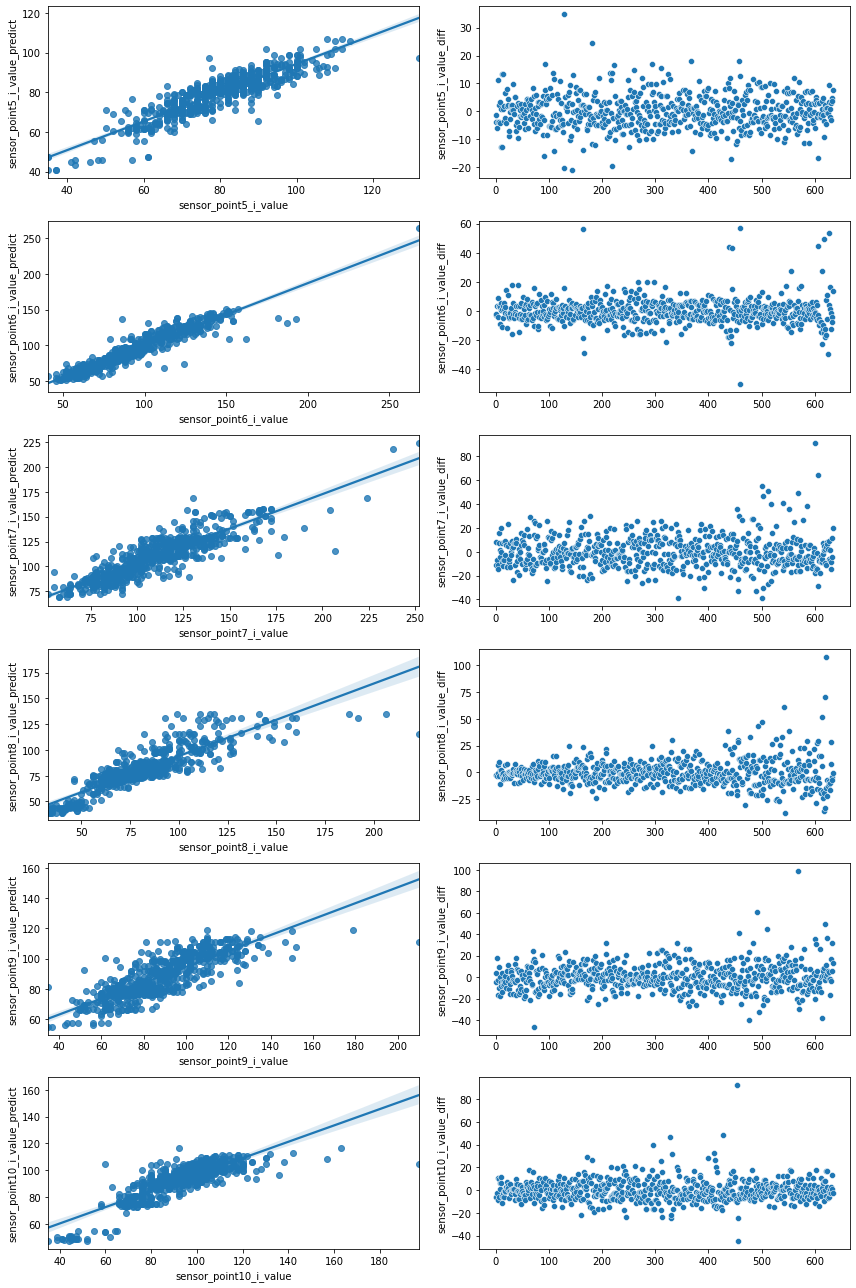

In [20]:
# 計算實際值跟預測值差異

data_T = Model_result # 資料類型
Model_ch = 'Cat' # 選擇 model

Y_predict_diff = data_y # 創建起始Table
for i in range(6):
    Y_predict_diff[data_y.columns.tolist()[i] + '_predict'] = data_T[Model_ch + '_' + data_y.columns.tolist()[i]]
    Y_predict_diff[data_y.columns.tolist()[i] + '_diff'] = data_T['Actual_' + data_y.columns.tolist()[i]]\
                                                            - data_T[Model_ch + '_' + data_y.columns.tolist()[i]]
# display(Y_predict_diff)

# seaborn呈現結果
fig, axes = plt.subplots(6, 2, figsize=(12, 18))

for i in range(6):
    # 預測值跟實際值分布狀況
    sns.regplot(x = data_y.columns.tolist()[i], 
                y = data_y.columns.tolist()[i] + '_predict', 
                data = Y_predict_diff, 
                ax=axes[i, 0])
    
    # 每筆資料的差異
    sns.scatterplot(x = Y_predict_diff.index,
                    y = data_y.columns.tolist()[i] + '_diff',
                    data = Y_predict_diff, 
                    ax=axes[i, 1])
    
    
plt.tight_layout()